Connect Four – Predictive MinMax: Final Analysis

Questo notebook raccoglie e analizza i risultati sperimentali delle strategie:

- **A**: Baseline (L, K costanti)
- **D**: Curriculum aggressivo
- **E**: Curriculum v3 (con vincolo K = 2L + 1)

Per ciascuna strategia analizziamo:
- andamento della loss di training,
- valutazione offline (MSE, correlazione con MinMax profondo),
- win-rate vs random,
- confronti head-to-head tra strategie.

In [89]:
# %%
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Per i grafici inline
%matplotlib inline

# Imposta la root del progetto (modifica il path se sposti la cartella)
PROJECT_ROOT = r"C:\Users\marco\Desktop\IA\Caianiello\predictive-minmax"
if os.path.isdir(PROJECT_ROOT):
    os.chdir(PROJECT_ROOT)

print("Working directory:", os.getcwd())


def set_global_seed(seed: int = 0):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_global_seed(0)

# Mapping delle strategie e relativi file CSV / checkpoint
STRATEGY_INFO = {
    "A": {
        "name": "Baseline (L,K costanti)",
        "csv": "results/connect4_baseline_seed0_L2K4.csv",
        "ckpt": "results/model_strategy_A.pth",
    },
    "D": {
        "name": "Curriculum aggressivo (Strategy D)",
        "csv": "results/connect4_curriculum_seed0_D.csv",
        "ckpt": "results/model_strategy_D.pth",
    },
    "E": {
        "name": "Curriculum v3 (K = 2L+1)",
        "csv": "results/connect4_curriculum_seed0_E.csv",
        "ckpt": "results/model_strategy_E.pth",
    },
}

STRATEGY_INFO


Working directory: C:\Users\marco\Desktop\IA\Caianiello\predictive-minmax


{'A': {'name': 'Baseline (L,K costanti)',
  'csv': 'results/connect4_baseline_seed0_L2K4.csv',
  'ckpt': 'results/model_strategy_A.pth'},
 'D': {'name': 'Curriculum aggressivo (Strategy D)',
  'csv': 'results/connect4_curriculum_seed0_D.csv',
  'ckpt': 'results/model_strategy_D.pth'},
 'E': {'name': 'Curriculum v3 (K = 2L+1)',
  'csv': 'results/connect4_curriculum_seed0_E.csv',
  'ckpt': 'results/model_strategy_E.pth'}}

1. Caricamento dei log di training (CSV)

Carichiamo i file CSV prodotti dagli script di training delle quattro strategie
e li unifichiamo in un unico DataFrame `logs_all`, con una colonna `strategy`
che indica a quale strategia appartiene ciascuna riga.

In [90]:
def load_logs_for_strategy(strategy_key: str) -> pd.DataFrame:
    """
    Carica il CSV associato a una strategy (A/D/E) e aggiunge la colonna 'strategy'.
    """
    info = STRATEGY_INFO[strategy_key]
    csv_path = info["csv"]

    if not os.path.exists(csv_path):
        print(f"[WARN] CSV non trovato per strategy {strategy_key}: {csv_path}")
        return pd.DataFrame()

    df = pd.read_csv(csv_path)
    df["strategy"] = strategy_key
    return df

dfs = []
for s in ["A", "D", "E"]:   # <-- solo queste tre
    df_s = load_logs_for_strategy(s)
    if not df_s.empty:
        dfs.append(df_s)

logs_all = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

print("Righe per strategy:")
print(logs_all["strategy"].value_counts())
logs_all.head()


Righe per strategy:
strategy
A    100
D    100
E    100
Name: count, dtype: int64


,seed,iter,L,K,batch_size,loss,wins_vs_random,draws_vs_random,losses_vs_random,strategy
0,0,1,2,4,175,0.942482,NaN,NaN,NaN,A
1,0,2,2,4,205,0.972917,NaN,NaN,NaN,A
2,0,3,2,4,170,1.059687,NaN,NaN,NaN,A
3,0,4,2,4,195,0.996093,NaN,NaN,NaN,A
4,0,5,2,4,190,1.078578,NaN,NaN,NaN,A


2. Statistiche riassuntive sui log

Osserviamo le statistiche descrittive (iterazioni, L, K, batch_size, loss, ecc.)
per verificare che tutte le strategie abbiano lo stesso budget di training
(T_max e N_selfplay_per_iter) e che i log contengano le colonne che ci servono.

In [102]:
# %%
if logs_all.empty:
    print("logs_all è vuoto: non ci sono CSV caricati, ricontrollare i path.")
else:
    display(logs_all.describe(include="all"))


,seed,iter,L,K,batch_size,loss,wins_vs_random,draws_vs_random,losses_vs_random,strategy
count,300.0,300.000000,300.000000,300.000000,300.000000,300.000000,30.000000,30.000000,30.000000,300
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
mean,0.0,50.500000,2.366667,5.400000,141.850000,0.804752,8.533333,0.933333,10.533333,NaN
std,0.0,28.914301,0.632632,1.521309,54.507471,0.431525,4.546566,1.080655,4.216007,NaN
min,0.0,1.000000,1.000000,3.000000,35.000000,0.004574,0.000000,0.000000,4.000000,NaN
25%,0.0,25.750000,2.000000,4.000000,105.000000,0.528582,4.000000,0.000000,6.500000,NaN
50%,0.0,50.500000,2.000000,5.000000,155.000000,0.772146,9.000000,1.000000,10.000000,NaN
75%,0.0,75.250000,3.000000,7.000000,190.000000,1.028224,12.000000,1.000000,14.500000,NaN


3. Grafici di training

In questa sezione definiamo funzioni di utilità per:

- plottare la **loss di training** per iterazione;
- plottare il **win-rate vs random** per iterazione (dove disponibile).

In [92]:
# %%
def plot_loss_curves(logs: pd.DataFrame):
    """
    Plot della loss di training (MSE) contro l'iterazione, per ogni strategia.
    """
    if logs.empty:
        print("Nessun log da plottare.")
        return

    plt.figure(figsize=(8, 5))
    for s, df_s in logs.groupby("strategy"):
        plt.plot(df_s["iter"], df_s["loss"], marker="o", label=f"Strategy {s}")
    plt.xlabel("Iteration")
    plt.ylabel("Training loss (MSE)")
    plt.title("Training loss vs iteration")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def build_winrate_by_iter(logs: pd.DataFrame) -> pd.DataFrame:
    """
    Costruisce un DataFrame con il winrate vs random *per iterazione*, per ogni strategia.
    Sono utilizzati solo i record in cui wins_vs_random, draws_vs_random, losses_vs_random
    sono non-null (tipicamente ogni 10 iterazioni).
    """
    if logs.empty:
        return pd.DataFrame()

    # Consideriamo solo le righe dove abbiamo effettivamente giocato vs random
    mask = logs["wins_vs_random"].notna()
    df_eval = logs[mask].copy()

    # Calcolo del winrate per iterazione e strategia
    df_eval["games"] = (
        df_eval["wins_vs_random"] +
        df_eval["draws_vs_random"] +
        df_eval["losses_vs_random"]
    )
    df_eval["winrate"] = df_eval["wins_vs_random"] / df_eval["games"]

    return df_eval[["strategy", "iter", "winrate"]]


def plot_winrate_curves(df_eval: pd.DataFrame):
    """
    Plot del winrate vs random in funzione dell'iterazione per ogni strategia.
    """
    if df_eval.empty:
        print("Nessun dato di winrate vs random da plottare.")
        return

    plt.figure(figsize=(8, 5))
    for s, df_s in df_eval.groupby("strategy"):
        plt.plot(df_s["iter"], df_s["winrate"], marker="o", label=f"Strategy {s}")
    plt.xlabel("Iteration")
    plt.ylabel("Win rate vs random")
    plt.ylim(0, 1.05)
    plt.title("Win rate vs random vs iteration")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


3.1 Loss di training

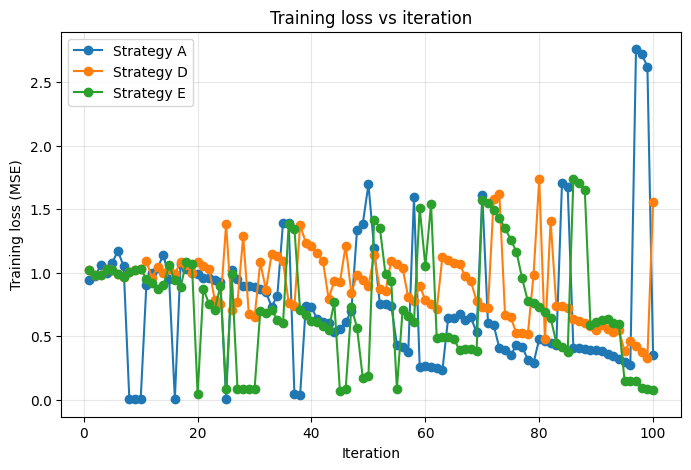

In [93]:
# %%
plot_loss_curves(logs_all)


3.2 Win-rate vs random (per iterazione)

In [94]:
# %%
df_winrate_iter = build_winrate_by_iter(logs_all)
df_winrate_iter


,strategy,iter,winrate
9,A,10,0.20
19,A,20,0.50
29,A,30,0.45
39,A,40,0.20
49,A,50,0.35
59,A,60,0.20
69,A,70,0.30
79,A,80,0.20
89,A,90,0.00
99,A,100,0.10


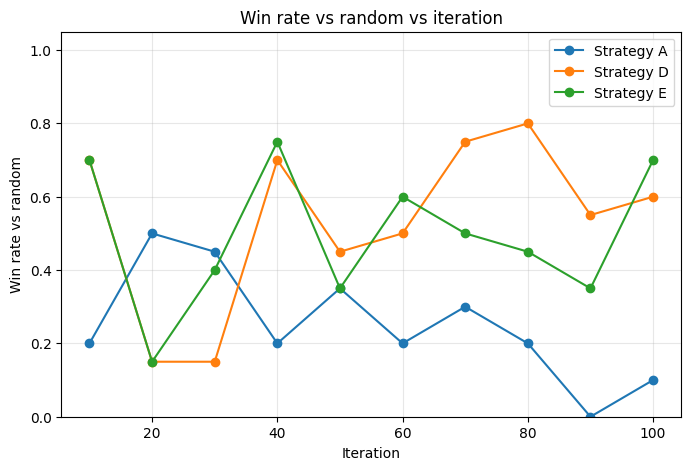

In [95]:
# %%
plot_winrate_curves(df_winrate_iter)


4. Valutazione offline

Qui misuriamo quanto l'euristica neurale \\( H_{\\text{true}} \\) approssima
i valori forniti da un MinMax più profondo (senza euristica) su un insieme
di stati di test generati con partite random corte.

Per ogni strategia:
- carichiamo il checkpoint del modello,
- generiamo un insieme di stati,
- calcoliamo MSE e correlazione Pearson rispetto a MinMax.

In [ ]:
# %%
from experiments.eval_offline_connect4 import generate_test_states
from utils.encoding import state_to_np_array

class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def offline_eval_checkpoint(ckpt_path: str,
                            n_states: int = 200,
                            seed: int = 0,
                            device: str = "cpu"):
    """
    Carica un MLP dal checkpoint `ckpt_path` e calcola MSE + correlazione
    rispetto ai valori 'veri' approssimati via MinMax (generate_test_states).
    """
    rows, cols = 6, 7
    input_dim = rows * cols

    if not os.path.exists(ckpt_path):
        print(f"[WARN] checkpoint non trovato: {ckpt_path}")
        return None, None

    model = MLP(input_dim=input_dim, hidden_dim=128)
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    states, true_vals = generate_test_states(
        n=n_states,
        max_random_moves=12,
        seed=seed
    )

    preds = []
    with torch.no_grad():
        for s in states:
            x_np = state_to_np_array(s)
            x = torch.tensor(x_np, dtype=torch.float32, device=device).unsqueeze(0)
            preds.append(model(x).item())

    preds = np.array(preds, dtype=float)
    true_vals = np.array(true_vals, dtype=float)

    mse = float(np.mean((preds - true_vals) ** 2))

    if np.std(preds) == 0.0 or np.std(true_vals) == 0.0:
        corr = 0.0
    else:
        corr = float(np.corrcoef(preds, true_vals)[0, 1])

    return mse, corr


In [97]:
# %%
results_offline = []

for s, info in STRATEGY_INFO.items():
    ckpt = info["ckpt"]
    print(f"== Strategy {s} ({info['name']}) ==")
    mse, corr = offline_eval_checkpoint(ckpt, n_states=200, seed=0, device="cpu")
    print("  MSE:", mse, "| corr:", corr)
    results_offline.append({
        "strategy": s,
        "name": info["name"],
        "mse_offline": mse,
        "corr_offline": corr,
    })

df_offline = pd.DataFrame(results_offline)
df_offline


== Strategy A (Baseline (L,K costanti)) ==
  MSE: 0.2739991988939692 | corr: 0.09921616170744485
== Strategy D (Curriculum aggressivo (Strategy D)) ==
  MSE: 0.17426148589396348 | corr: 0.17492339502478416
== Strategy E (Curriculum v3 (K = 2L+1)) ==
  MSE: 0.1817152180642308 | corr: 0.1382025815899038


,strategy,name,mse_offline,corr_offline
0,A,"Baseline (L,K costanti)",0.273999,0.099216
1,D,Curriculum aggressivo (Strategy D),0.174261,0.174923
2,E,Curriculum v3 (K = 2L+1),0.181715,0.138203


5. Valutazione vs random (100 partite finali)

Qui utilizziamo la funzione di valutazione `evaluate_vs_random` definita
in `experiments/eval_vs_random_connect4.py` per stimare la forza di gioco
di ciascuna strategia contro un avversario random, usando i checkpoint finali.

In [98]:
# %%
from experiments.eval_vs_random_connect4 import evaluate_vs_random

results_vs_random = []

for s, info in STRATEGY_INFO.items():
    ckpt = info["ckpt"]
    print(f"== Strategy {s} ({info['name']}) ==")
    if not os.path.exists(ckpt):
        print(f"  [SKIP] checkpoint non trovato: {ckpt}")
        results_vs_random.append({
            "strategy": s,
            "name": info["name"],
            "wins": None,
            "draws": None,
            "losses": None,
            "winrate": None,
        })
        continue

    # L,K scelti coerenti con l'idea di ciascuna strategia
    if s == "A":
        L, K = 2, 4          # baseline
    elif s == "D":
        L, K = 3, 7          # curriculum aggressivo
    else:  # "E"
        L, K = 3, 7          # curriculum v3 con K ≈ 2L+1

    w, d, l = evaluate_vs_random(ckpt, L=L, K=K, n_games=100, device="cpu")
    total = w + d + l
    wr = w / total if total > 0 else None

    results_vs_random.append({
        "strategy": s,
            "name": info["name"],
            "wins": w,
            "draws": d,
            "losses": l,
            "winrate": wr,
    })

df_vs_random = pd.DataFrame(results_vs_random)
df_vs_random



== Strategy A (Baseline (L,K costanti)) ==
Valutazione vs random (results/model_strategy_A.pth):
  L=2, K=4, games=100
  W/D/L = 94/0/6
== Strategy D (Curriculum aggressivo (Strategy D)) ==
Valutazione vs random (results/model_strategy_D.pth):
  L=3, K=7, games=100
  W/D/L = 97/0/3
== Strategy E (Curriculum v3 (K = 2L+1)) ==
Valutazione vs random (results/model_strategy_E.pth):
  L=3, K=7, games=100
  W/D/L = 94/0/6


,strategy,name,wins,draws,losses,winrate
0,A,"Baseline (L,K costanti)",94,0,6,0.94
1,D,Curriculum aggressivo (Strategy D),97,0,3,0.97
2,E,Curriculum v3 (K = 2L+1),94,0,6,0.94


6. Head-to-head tra strategie

Facciamo scontrare le strategie tra loro per vedere se le varianti
curriculum sono effettivamente più forti del baseline **A** e tra di loro.

Esempi:
- D vs A
- E vs A

In [99]:
from experiments.eval_head_to_head_connect4 import head_to_head

results_h2h = []

def add_h2h(new_key: str, old_key: str, L: int, K: int, n_games: int = 50):
    if os.path.exists(STRATEGY_INFO[new_key]["ckpt"]) and os.path.exists(STRATEGY_INFO[old_key]["ckpt"]):
        wins_new, draws, losses_new = head_to_head(
            path_new=STRATEGY_INFO[new_key]["ckpt"],
            path_old=STRATEGY_INFO[old_key]["ckpt"],
            L=L,
            K=K,
            n_games=n_games,
            device="cpu",
        )
        total = wins_new + draws + losses_new
        wr = wins_new / total if total > 0 else None
        results_h2h.append({
            "new": new_key,
            "old": old_key,
            "wins_new": wins_new,
            "draws": draws,
            "losses_new": losses_new,
            "winrate_new": wr,
        })
    else:
        print(f"[SKIP] mancano checkpoint per {new_key} vs {old_key}")

# Confronti che vogliamo tenere
add_h2h("D", "A", L=3, K=7, n_games=50)
add_h2h("E", "A", L=3, K=7, n_games=50)
add_h2h("E", "D", L=3, K=7, n_games=50)

df_h2h = pd.DataFrame(results_h2h)
df_h2h


Head-to-head NEW(results/model_strategy_D.pth) vs OLD(results/model_strategy_A.pth):
  L=3, K=7, games=50
  NEW W/D/L = 0/0/50
Head-to-head NEW(results/model_strategy_E.pth) vs OLD(results/model_strategy_A.pth):
  L=3, K=7, games=50
  NEW W/D/L = 0/0/50
Head-to-head NEW(results/model_strategy_E.pth) vs OLD(results/model_strategy_D.pth):
  L=3, K=7, games=50
  NEW W/D/L = 0/0/50


,new,old,wins_new,draws,losses_new,winrate_new
0,D,A,0,0,50,0.0
1,E,A,0,0,50,0.0
2,E,D,0,0,50,0.0


7. Valutazione online vs random
 Qui riutilizziamo `evaluate_vs_random` dallo script
 `experiments.eval_vs_random_connect4.py` per calcolare W/D/L
 per ciascuna strategia.

In [100]:
from experiments.eval_vs_random_connect4 import evaluate_vs_random

results_vs_random = []

for s, info in STRATEGY_INFO.items():
    ckpt = info["ckpt"]
    print(f"== Strategy {s} ({info['name']}) ==")
    if not os.path.exists(ckpt):
        print(f"  [SKIP] checkpoint non trovato: {ckpt}")
        results_vs_random.append({
            "strategy": s,
            "name": info["name"],
            "wins": None,
            "draws": None,
            "losses": None,
            "winrate": None,
        })
        continue

    # L,K scelte per ogni strategia (coerenti con il loro “spirito”)
    if s == "A":
        L, K = 2, 4
    elif s == "D":
        L, K = 3, 7
    elif s == "E":
        L, K = 3, 7   # o 3, 2*3+1 se vuoi allinearti alla legge K=2L+1

    w, d, l = evaluate_vs_random(ckpt, L=L, K=K, n_games=100, device="cpu")
    total = w + d + l
    wr = w / total if total > 0 else None

    results_vs_random.append({
        "strategy": s,
            "name": info["name"],
            "wins": w,
            "draws": d,
            "losses": l,
            "winrate": wr,
    })

df_vs_random = pd.DataFrame(results_vs_random)
df_vs_random


== Strategy A (Baseline (L,K costanti)) ==
Valutazione vs random (results/model_strategy_A.pth):
  L=2, K=4, games=100
  W/D/L = 96/1/3
== Strategy D (Curriculum aggressivo (Strategy D)) ==
Valutazione vs random (results/model_strategy_D.pth):
  L=3, K=7, games=100
  W/D/L = 99/0/1
== Strategy E (Curriculum v3 (K = 2L+1)) ==
Valutazione vs random (results/model_strategy_E.pth):
  L=3, K=7, games=100
  W/D/L = 98/0/2


,strategy,name,wins,draws,losses,winrate
0,A,"Baseline (L,K costanti)",96,1,3,0.96
1,D,Curriculum aggressivo (Strategy D),99,0,1,0.99
2,E,Curriculum v3 (K = 2L+1),98,0,2,0.98


7. Riassunto finale dei risultati

In questa ultima sezione potresti unire i risultati principali in una tabella
riassuntiva (ad esempio unendo win-rate vs random e MSE offline) per avere
una vista compatta da riportare nel report.

In [101]:
# %%
# Merge di offline + vs_random (join per strategy)
df_summary = (
    df_offline.set_index("strategy")
    .join(df_vs_random.set_index("strategy"), lsuffix="_offline", rsuffix="_vsrandom")
    .reset_index()
)

df_summary


,strategy,name_offline,mse_offline,corr_offline,name_vsrandom,wins,draws,losses,winrate
0,A,"Baseline (L,K costanti)",0.273999,0.099216,"Baseline (L,K costanti)",96,1,3,0.96
1,D,Curriculum aggressivo (Strategy D),0.174261,0.174923,Curriculum aggressivo (Strategy D),99,0,1,0.99
2,E,Curriculum v3 (K = 2L+1),0.181715,0.138203,Curriculum v3 (K = 2L+1),98,0,2,0.98
